In [14]:
import cPickle
import gzip
# First from notebook 11 L(ZOGY) data: (im1, im2, im1_psf, im2_psf, conv_im1, pci, pcf)
LZOGY = cPickle.load(gzip.GzipFile("11_results.p.gz", "rb"))
# Next from notebook 12 ZOGY data: (im1, im2, im1_psf, im2_psf, D, P_D)
ZOGY = cPickle.load(gzip.GzipFile("12_results.p.gz", "rb"))

In [15]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

x = np.arange(-15, 16, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))

xim = np.arange(-255, 256, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))

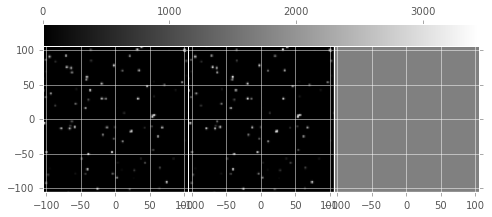

In [16]:
# Make sure they're the same!!!
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (9, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (-255+150, 256-150, -255+150, 256-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(LZOGY[0][x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(ZOGY[0][x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow((LZOGY[0]-ZOGY[0])[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1))
igrid.cbar_axes[0].colorbar(gim)

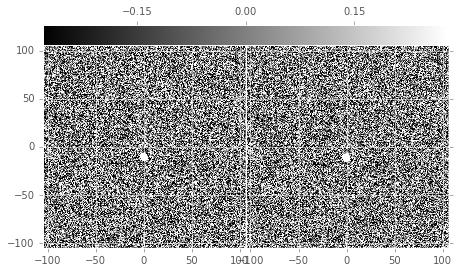

In [17]:
# Compare the optimal diffim's:
fig = plt.figure(1, (8, 4))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (-255+150, 256-150, -255+150, 256-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(LZOGY[5][x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-0.28,0.28))
igrid[1].imshow(ZOGY[4][x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1))
igrid.cbar_axes[0].colorbar(gim)

-2.89076752791 2.88824582029
0.286047604501 0.981567813914
10.2914037249 36.0020985187
35.9779406048 36.6781571363


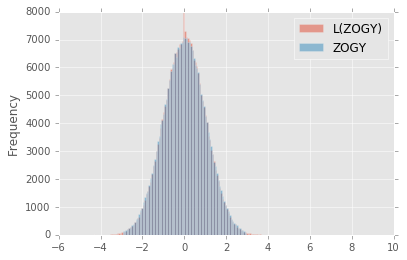

In [21]:
d1 = LZOGY[5]
d2 = ZOGY[4]

import scipy.stats
_, low, upp = scipy.stats.sigmaclip([d1, d2])
print low, upp
d1a = d1[(d1>low) & (d1<upp) & (d2>low) & (d2<upp)]
d2a = d2[(d1>low) & (d1<upp) & (d2>low) & (d2<upp)]
df = pd.DataFrame({'L(ZOGY)': d1a.flatten()/d1a.std(), 'ZOGY': d2a.flatten()/d2a.std()})
df.plot.hist(alpha=0.5, bins=200)

print d1a.std(), d2a.std()
print d1.max(), d2.max()
print d1.max()/d1a.std(), d2.max()/d2a.std()

Looks like there's a scale factor issue here - the $\sigma$ of the L(ZOGY) diffim equals $\sqrt{\sigma_1^2 + \sigma_2^2)}$ and that of the ZOGY diffim is $\approx 1$.

Note this is stated in the ZOGY paper, section 5, step 17. of their algorithm summary.

Note this could also be because I did not include the $\sigma$'s in the A&L implementation (BAD!)

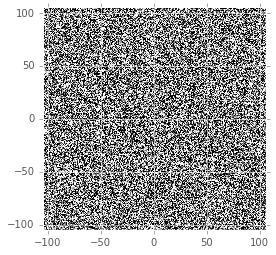

In [19]:
plt.imshow(d1/d1a.std() - d2/d2a.std(), origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1))

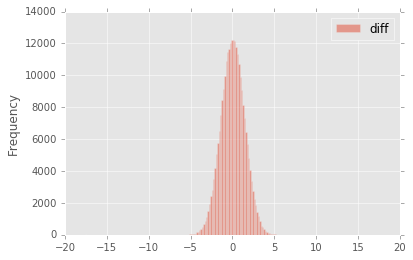

In [20]:
df = pd.DataFrame({'diff': (d1/d1a.std() - d2/d2a.std()).flatten()})
df.plot.hist(alpha=0.5, bins=200)

There is a weird 1 pixel offset in the L(ZOGY) post-convolution kernel that I am computing. This could be leading to the differences between the images (I bet it's a 1-pixel offset in the noise that we're seeing here).